In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip uninstall keras
!pip install tensorflow==2.12 transformers==4.30

In [ ]:
!pip install transformers==4.28.1

In [ ]:
!pip install gensim


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer#, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tqdm import tqdm

# Misc.
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import tensorflow as tf
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import TFDistilBertModel

from tqdm import tqdm

In [ ]:
#DATA PREPROCESSING

In [ ]:
df=pd.read_csv("BangBangSurvivor_reviews.csv.csv")

In [ ]:
# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower()  # Convert to lowercase
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatization & Stopword removal
    return tokens

# Apply preprocessing
df['processed_reviews'] = df['text'].astype(str).apply(preprocess_text)

# Create bigram and trigram models
bigram = Phrases(df['processed_reviews'], min_count=5, threshold=100)
bigram_mod = Phraser(bigram)
trigram = Phrases(bigram[df['processed_reviews']], threshold=100)
trigram_mod = Phraser(trigram)

# Apply bigrams and trigrams
df['processed_reviews'] = df['processed_reviews'].apply(lambda x: trigram_mod[bigram_mod[x]])

# Create Dictionary and Corpus
dictionary = corpora.Dictionary(df['processed_reviews'])
dictionary.filter_extremes(no_below=5, no_above=0.5)  # Remove rare and overly common words
corpus = [dictionary.doc2bow(text) for text in df['processed_reviews']]

In [ ]:
#TEXTBLOB SENTIMENT ANALYSIS

In [ ]:
from textblob import TextBlob
df = df.dropna(subset=['text']).copy()
def classify_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.2:
        return 'Negative'
    else:
        return 'Neutral'
# Step 4: Apply the function to the 'text' column
df['Sentiment_textblob'] = df['text'].apply(classify_sentiment)

# Optional: View the sentiment distribution
print(df['Sentiment'].value_counts())

In [ ]:
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 5))
sns.histplot(df['polarity'], kde=True, bins=40, color='skyblue')
plt.title("Distribution of Sentiment Polarity (TextBlob)")
plt.xlabel("Polarity Score")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

#Sentiment by Rating (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='rating', y='polarity', palette='Spectral')
plt.title("Sentiment Polarity by User Rating")
plt.xlabel("Rating")
plt.ylabel("Polarity")
plt.tight_layout()
plt.show()

#Sentiment Polarity vs Review Length (Scatter Plot)
df['review_length'] = df['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='review_length', y='polarity', hue='Sentiment', alpha=0.7)
plt.title("Polarity vs Review Length by Sentiment")
plt.xlabel("Review Length (characters)")
plt.ylabel("Polarity")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

In [ ]:
#BERT SENTIMENT ANALYSIS

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 4
BATCH_SIZE = 16
MAX_LEN = 128

label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
reverse_map = {v: k for k, v in label_map.items()}

df['label'] = df['Sentiment'].map(label_map)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")
        self.labels = torch.tensor(labels.values)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'label': self.labels[idx]
        }

X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
val_indices = X_val.index

train_dataset = ReviewDataset(X_train, y_train)
val_dataset = ReviewDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
bert_model = bert_model.to(DEVICE)

optimizer = AdamW(bert_model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    correct = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct.double() / len(data_loader.dataset), sum(losses) / len(losses)
    
def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct += torch.sum(preds == labels)
            losses.append(loss.item())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return correct.double() / len(data_loader.dataset), sum(losses) / len(losses), all_preds, all_labels
    
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_acc, train_loss = train_epoch(bert_model, train_loader, loss_fn, optimizer, DEVICE)
    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")

    val_acc, val_loss, _, _ = eval_model(bert_model, val_loader, loss_fn, DEVICE)
    print(f"Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}")

In [ ]:
full_encodings = tokenizer(list(df['text']), truncation=True, padding=True, max_length=128, return_tensors='pt') # Change to 'pt'

full_preds = []
with torch.no_grad():
    for i in range(0, full_encodings['input_ids'].shape[0], 16):  # Batch size of 16
        batch_encodings = {k: v[i:i+16].to(DEVICE) for k, v in full_encodings.items()}
        outputs = bert_model(**batch_encodings).logits
        batch_preds = torch.argmax(outputs, dim=1).cpu().numpy()
        full_preds.extend(batch_preds)

df['bert_sentiment'] = [reverse_map[i] for i in full_preds]

df.sample(5)

plt.figure(figsize=(10, 5))
sns.histplot(df['bert_sentiment'], kde=True, bins=40, color='skyblue')
plt.title("Distribution of Bert_Sentiment")
plt.xlabel("Bert_Sentiment")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

In [ ]:
#DISTILBERT SENTIMENT ANALYSIS

In [ ]:
distilbert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    list(y_train)
)).shuffle(100).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    list(y_test)
)).batch(16)

distilbert_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

distilbert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = distilbert_model.fit(train_dataset, epochs=10, validation_data=test_dataset)



In [ ]:
full_encodings = tokenizer(list(df['text']), truncation=True, padding=True, max_length=128, return_tensors='tf')

full_dataset = tf.data.Dataset.from_tensor_slices(dict(full_encodings)).batch(16)

full_logits = distilbert_model.predict(full_dataset).logits
full_preds = np.argmax(full_logits, axis=1)
df['distilbert_sentiment'] = [reverse_map[i] for i in full_preds]

plt.figure(figsize=(10, 5))
sns.histplot(df['distilbert_sentiment'], kde=True, bins=40, color='skyblue')
plt.title("Distribution of Bert_Sentiment")
plt.xlabel("Bert_Sentiment")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

In [ ]:
df[['text', 'Sentiment','Sentiment_textblob', 'distilbert_sentiment','bert_sentiment']].sample(15)

In [ ]:
#EVALUATION METRICS

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix for TextBlob
cm_textblob = confusion_matrix(df['Sentiment'], df['Sentiment_textblob'], labels=["Positive", "Neutral", "Negative"])

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_textblob, display_labels=["Positive", "Neutral", "Negative"])
fig, ax = plt.subplots()
disp.plot(cmap='Greens', ax=ax, colorbar=False)

# Remove frame, ticks, and spines for a cleaner look
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title("Confusion Matrix for TextBlob", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(df['Sentiment'], df['bert_sentiment'], labels=["Positive", "Neutral", "Negative"])

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Neutral", "Negative"])
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax, colorbar=False)

# Remove frame, ticks, and spines for a cleaner look
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title("Confusion Matrix for BERT", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(df['Sentiment'], df['distilbert_sentiment'], labels=["Positive", "Neutral", "Negative"])

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Neutral", "Negative"])
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax, colorbar=False)

# Remove frame, ticks, and spines for a cleaner look
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title("Confusion Matrix for DISTILBERT", fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(true, pred):
    return {
        'Accuracy': accuracy_score(true, pred),
        'Precision': precision_score(true, pred, average='macro'),
        'Recall': recall_score(true, pred, average='macro'),
        'F1 Score': f1_score(true, pred, average='macro')
    }

textblob_metrics = compute_metrics(sample_df['Sentiment'], sample_df['Sentiment_textblob'])
distilbert_metrics = compute_metrics(sample_df['Sentiment'], sample_df['distilbert_sentiment'])
bert_metrics = compute_metrics(sample_df['Sentiment'], sample_df['bert_sentiment'])

# Combine into one dictionary
model_scores = {
    'TextBlob': textblob_metrics,
    'DistilBERT': distilbert_metrics,
    'BERT': bert_metrics
}

# Plotting
labels = list(textblob_metrics.keys())  # Metric names
x = range(len(labels))  # X locations for groups

plt.figure(figsize=(10, 6))
bar_width = 0.25

# Plot each model's metrics
for i, (model, scores) in enumerate(model_scores.items()):
    plt.bar([p + i * bar_width for p in x], list(scores.values()), width=bar_width, label=model)

# Add labels, title, legend
plt.xticks([p + bar_width for p in x], labels)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Performance Metrics Comparison (TextBlob vs DistilBERT vs BERT)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show values on bars
for i, (model, scores) in enumerate(model_scores.items()):
    for j, score in enumerate(scores.values()):
        plt.text(j + i * bar_width, score + 0.02, f'{score:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
#SEMANTIC CLUSTERING

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ganes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Batches:   0%|          | 0/77 [00:00<?, ?it/s]

C:\ProgramData\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


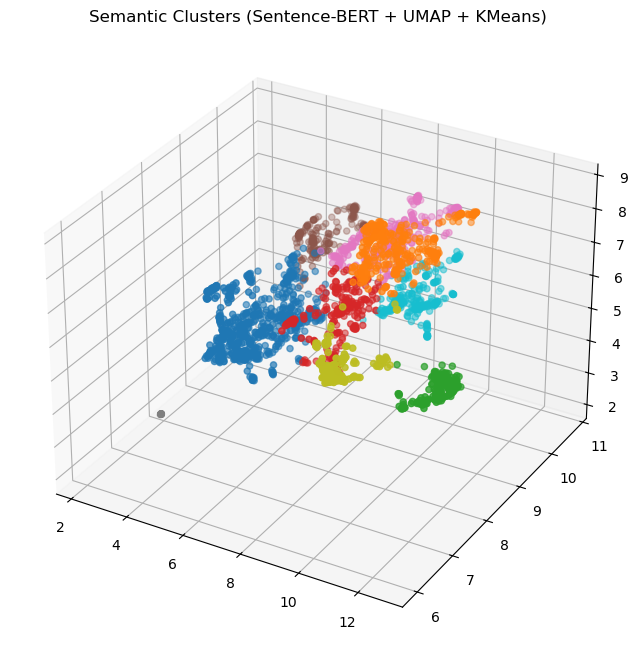

C:\Users\ganes\AppData\Local\Temp\ipykernel_30108\3139145016.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.values, y=cluster_counts.index, orient='h', palette='viridis')


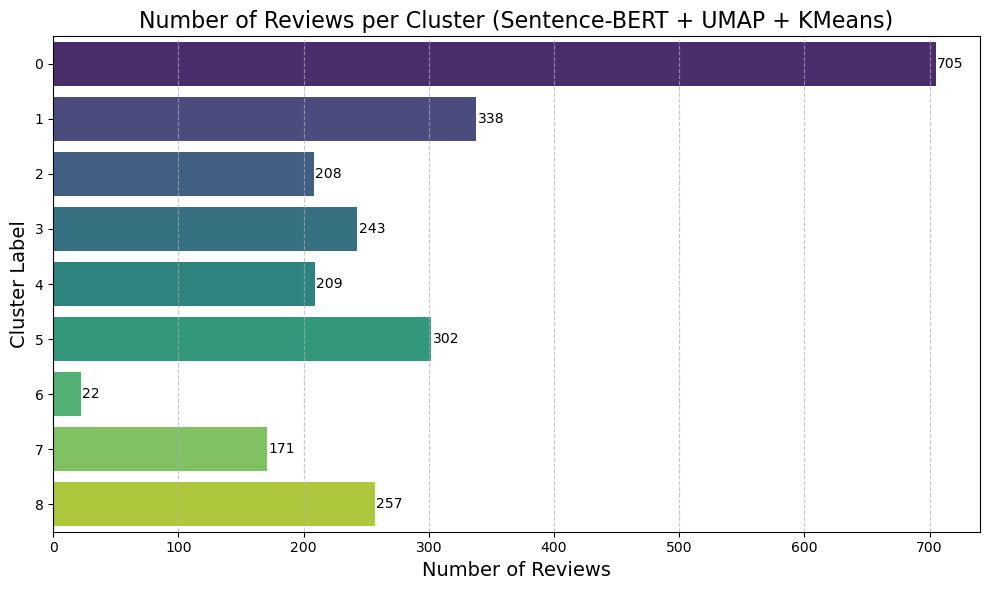

ModuleNotFoundError: No module named 'ace_tools'

In [6]:
# Re-execute after session reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import umap
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

# Download necessary NLTK resources
nltk.download('punkt')

# Load the data
df = pd.read_csv("BangBangSurvivor_reviews.csv")

# Step 1: Clean and filter data
def is_clean(text):
    if not isinstance(text, str):
        return False
    if len(text.split()) <= 3:
        return False
    if not text.isascii():
        return False
    if len(set(text)) <= 3:  # e.g. "!!!", "😂😂😂"
        return False
    return True

# Remove duplicates and noisy reviews
df['cleaned_review'] = df['text'].apply(lambda x: x.strip() if is_clean(x) else None)
df = df.dropna(subset=['cleaned_review'])
df = df.drop_duplicates(subset=['cleaned_review'])

# Step 2: Generate sentence-BERT embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
texts = df['cleaned_review'].tolist()
embeddings = model.encode(texts, batch_size=32, show_progress_bar=True)

# Step 3: UMAP for dimensionality reduction
umap_reducer = umap.UMAP(n_neighbors=15, n_components=3, min_dist=0.0, metric='cosine', random_state=42)
umap_embeddings = umap_reducer.fit_transform(embeddings)

# Step 4: Clustering using KMeans
NUM_CLUSTERS = 9
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
cluster_labels = kmeans.fit_predict(umap_embeddings)
df['cluster'] = cluster_labels

# Step 5: Plot UMAP clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], umap_embeddings[:, 2], c=cluster_labels, cmap='tab10')
ax.set_title("Semantic Clusters (Sentence-BERT + UMAP + KMeans)")
plt.show()

# Step 6: Plot number of reviews per cluster
cluster_counts = df['cluster'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.values, y=cluster_counts.index, orient='h', palette='viridis')
for i, (count, label) in enumerate(zip(cluster_counts.values, cluster_counts.index)):
    plt.text(count + 1, i, str(count), va='center', fontsize=10)
plt.title('Number of Reviews per Cluster (Sentence-BERT + UMAP + KMeans)', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=14)
plt.ylabel('Cluster Label', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [8]:
# Function to print top reviews per cluster
def print_cluster_examples(df, num_examples=5):
    for cluster_num in sorted(df['cluster'].unique()):
        print(f"\n🔵 Cluster {cluster_num}:")
        cluster_reviews = df[df['cluster'] == cluster_num]['text'].head(num_examples)
        for i, review in enumerate(cluster_reviews, 1):
            print(f"{i}. {review}")

# Run the function
print_cluster_examples(df, num_examples=5)


🔵 Cluster 0:
1. Definitely love this game I play it everyday I built up a strong winning team of characters in I would recommend this to anybody
2. As described. Lacking guidance. There are things out there it just leaves you to just figure out.
3. It is a Chinese game
4. I freaking love this game. I've never really gotten into these types of my games but this one just drew me in! Been playing for a while now even got the wife on it! Keep the updates coming and hopefully new attacks soon!
5. This is really fun game to play

🔵 Cluster 1:
1. Typical money hungry game. Difficulty level spikes up so fast you can't progress without throwing money at it and those "first purchase" options are ridiculous. 40$ for a character skin that barely increases your chance of winning. GTFO with your BS devs. Sad part is the game is cool, but just gets to an unplayable point without throwing away money on diamonds to have a CHANCE of winning decent gear, which btw is .005% as shown right on they're loot

C:\ProgramData\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


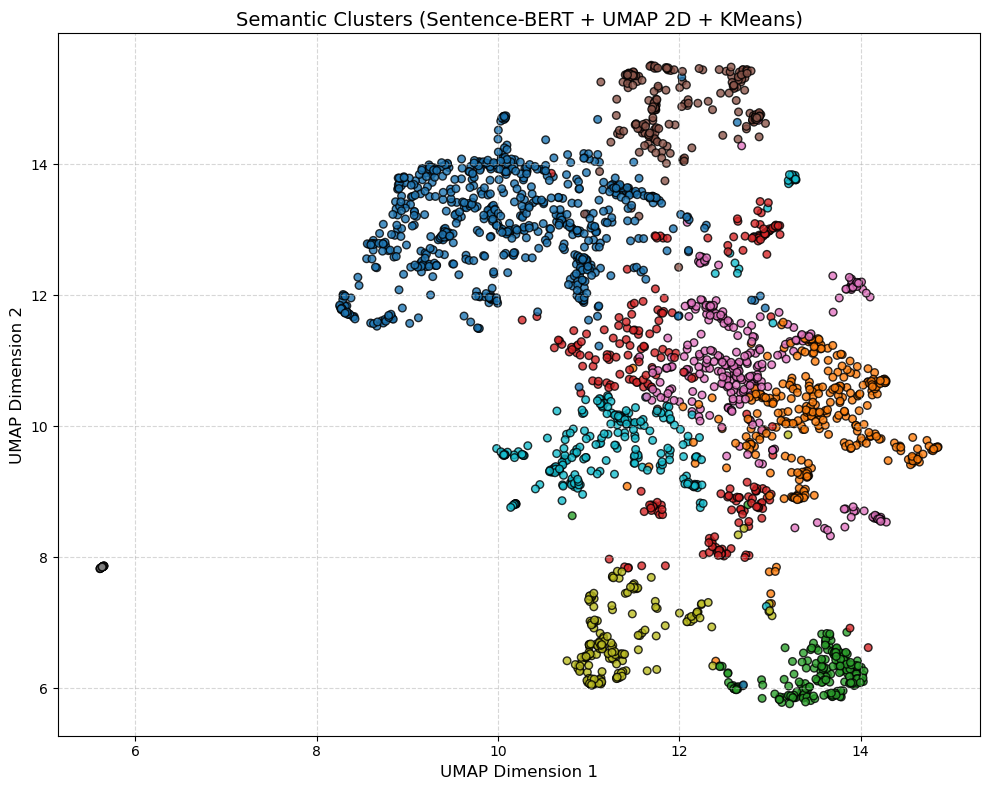

In [10]:
import umap
import matplotlib.pyplot as plt

# Step 1: Run 2D UMAP
umap_reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42)
umap_embeddings_2d = umap_reducer.fit_transform(embeddings)

# Step 2: Plot 2D clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    umap_embeddings_2d[:, 0],
    umap_embeddings_2d[:, 1],
    c=cluster_labels,
    cmap='tab10',
    s=30,
    alpha=0.8,
    edgecolors='k'
)
plt.title("Semantic Clusters (Sentence-BERT + UMAP 2D + KMeans)", fontsize=14)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Compute Silhouette Score
sil_score = silhouette_score(umap_embeddings, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

# Compute Davies-Bouldin Score
db_score = davies_bouldin_score(umap_embeddings, cluster_labels)
print(f"Davies-Bouldin Score: {db_score:.4f}")

Silhouette Score: 0.4206
Davies-Bouldin Score: 0.8504


In [ ]:
0.3880, 0.8848- BERT-9 clusters
0.3796, 0.9231- BERT-8 clusters
0.4058, 0.9258- SBERT-12 clusters
0.4075, 0.8443- SBERT-11 clusters
0.4176, 0.8555- SBERT-10 clusters
0.4206, 0.8504- SBERT-9 clusters
0.4197, 0.8427- SBERT-8 clusters
0.3914, 0.9641- SBERT-7 clusters
0.4151, 0.8780- SBERT-6 clusters
0.3694, 1.0487- SBERT-5 clusters
0.4199, 0.8524- SBERT-4 clusters